In [42]:
%pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 6.5 MB/s eta 0:00:00


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings('ignore')

from darts.models import TransformerModel
from darts.metrics import mape, mae
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import MeanAbsolutePercentageError
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from darts.utils.likelihood_models import QuantileRegression

# import optuna
# from optuna.integration import PyTorchLightningPruningCallback
# from optuna.visualization import (
#     plot_optimization_history,
#     plot_contour,
#     plot_param_importances,
# )

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
data = pd.read_parquet('/content/drive/MyDrive/TimeSeries/Mittelbuenden/train.parquet')
data['Date'] = pd.to_datetime(data['Date'], utc=True)
data.set_index('Date', inplace=True)
# # data = data.resample('H').sum(min_count=1)
# data = data.resample('D').sum(min_count=1)
data=data.sort_index()
data['Covid'] = 0
data['TimeIdx'] = np.arange(len(data))
data.loc[(data.index >= '2020-02-01') & (data.index <= '2021-06-01'), 'Covid'] = 1
TEST_END = '2022-09-01'
TRAIN_BEGIN = '2018-09-01'
TRAIN_END = '2021-09-01'
TRAIN_END = pd.to_datetime(TRAIN_END)
data = data.loc[(data.index < TEST_END) & (data.index >= TRAIN_BEGIN)]
# data['TimeIndex'] = np.arange(len(data))
# data = data.drop(columns=['TimeIndex'])
data

,Consumption,Temperature,Covid,TimeIdx
Date,,,,
2018-09-01 00:00:00+00:00,193045.634919,13.287500,0,243
2018-09-02 00:00:00+00:00,176660.680830,14.654167,0,244
2018-09-03 00:00:00+00:00,182018.412109,16.516667,0,245
2018-09-04 00:00:00+00:00,177651.235904,17.637500,0,246
2018-09-05 00:00:00+00:00,179125.881827,19.408333,0,247
...,...,...,...,...
2022-08-27 00:00:00+00:00,161911.593064,18.858333,0,1699
2022-08-28 00:00:00+00:00,149582.829196,19.729167,0,1700
2022-08-29 00:00:00+00:00,162369.865901,20.904167,0,1701


Data

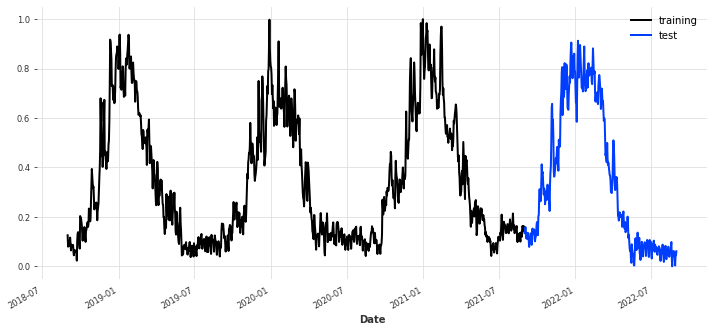

In [46]:
# from sklearn import preprocessing
# series_scaler = Scaler(scaler=preprocessing.StandardScaler())
series_scaler = Scaler()
series = TimeSeries.from_dataframe(df=data, value_cols='Consumption')
series_unsc = series
series = series_scaler.fit_transform(series)

# train, test = series[0:-365], series[-365-730:]
# train_unsc, test_unsc = series_unsc[0:-365], series_unsc[-365-730:]

train, test = series.split_before(TRAIN_END)
train_unsc, test_unsc = series_unsc.split_before(TRAIN_END)

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
test.plot(label='test')
plt.legend()

Covariates

Text(0.5, 1.0, 'Covariates (Covid)')

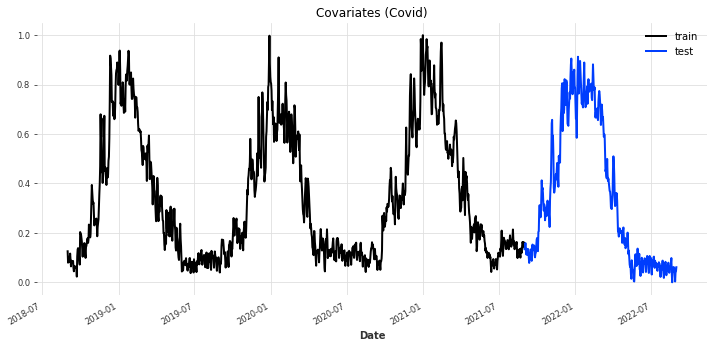

In [47]:
covid = TimeSeries.from_dataframe(df=data, value_cols='Covid')
covid = covid[1:] # it's somehow longer than the others
year = datetime_attribute_timeseries(series, attribute="year")
month = datetime_attribute_timeseries(series, attribute="month", cyclic=True)
weekday = datetime_attribute_timeseries(series, attribute="weekday", cyclic=True)
dayofyear = datetime_attribute_timeseries(series, attribute="dayofyear", cyclic=True)
temperature = TimeSeries.from_dataframe(df=data, value_cols='Temperature')
timeidx = TimeSeries.from_dataframe(df=data, value_cols='TimeIdx')

past_scaler = Scaler()


### future and past
# past_covariates = temperature.stack(dayofyear).stack(year).stack(month).stack(weekday)#.stack(covid)
past_covariates = temperature.stack(dayofyear)#.stack(covid)
past_covariates = past_scaler.fit_transform(past_covariates)


plt.figure(101, figsize=(12, 5))
# past_covariates.plot()
train.plot(label='train')
test.plot(label='test')
plt.title("Covariates (Covid)")

Follow this: https://unit8co.github.io/darts/userguide/hyperparameter_optimization.html?highlight=tuning

In [ ]:
import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping

from darts.metrics import smape

QUANTILES = [0.01, 0.5, 0.99]
# define objective function
def objective(trial):
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    # kernel_size = trial.suggest_int("kernel_size", 2, 5)
    # num_filters = trial.suggest_int("num_filters", 1, 5)
    # dilation_base = trial.suggest_int("dilation_base", 2, 4)
    # # dropout = trial.suggest_float("dropout", 0.0, 0.4)
    # num_layers = trial.suggest_int("num_layers", 1, 2)

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    callbacks = [early_stopper]
    pl_trainer_kwargs = {"callbacks": callbacks}

    # reproducibility
    torch.manual_seed(16)

    model = TransformerModel(
                        input_chunk_length = 365*2,
                        output_chunk_length = 365,
                        model_name = 'testModel',
                        d_model = 32,
                        nhead = 4,
                        num_encoder_layers = 4,
                        num_decoder_layers = 4,
                        dim_feedforward = 128,
                        dropout = 0.1,
                        activation = 'relu',
                        random_state=16,
                        likelihood=QuantileRegression(quantiles=QUANTILES), 
                        optimizer_kwargs={'lr': lr},
                        pl_trainer_kwargs=pl_trainer_kwargs,
                        save_checkpoints=True,
                        force_reset=True
                        )


    model.fit(series=train,
        past_covariates=past_covariates,
        val_series=test,
        val_past_covariates=past_covariates,
        epochs=100,
)

    # reload best model over course of training
    model = TCNModel.load_from_checkpoint("testModel")

    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(n=365, past_covariates=past_covariates, num_samples=20)
    preds = series_scaler.inverse_transform(preds)
    mape_val = mape(test_unsc, preds)

    return mape_val if mape_val != np.nan else float("inf")



# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, callbacks=[print_callback])

[I 2023-01-18 17:08:02,039] A new study created in memory with name: no-name-0c681001-3a19-48f4-8ba4-8c5f9d236deb
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 320   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 118 K 
6 | decoder             | Linear              | 36.1 K
------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

[W 2023-01-18 17:08:43,269] Trial 0 failed with parameters: {'lr': 0.0006985986301189776} because of the following error: NameError("name 'TCNModel' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-8-088b22f05a31>", line 56, in objective
    model = TCNModel.load_from_checkpoint("testModel")
NameError: name 'TCNModel' is not defined
[W 2023-01-18 17:08:43,272] Trial 0 failed with value None.


NameError: ignored

TCN: Best value: 15.454095864958163, Best params: {'lr': 0.000520232794395858, 'kernel_size': 2, 'num_filters': 3, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.08887844939494527, 'num_layers': 2}

TCN: Best value: 13.744765946406451, Best params: {'lr': 0.000618425018533039, 'kernel_size': 4, 'num_filters': 4, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.23796656917959533}

lstm=2, lr = 0.005
{'lr': 0.0012908197023598974, 'dropout': 0.042463807569482585, 'input_chunk_length': 14, 'hidden_size': 22, 'hidden_continuous_size': 22, lstm=2, attenuationheads=4, batchsize=32 glaub}


Full_Attenuation=True {'lr': 0.0008870003710495735, 'dropout': 0.08350420613230446, 'input_chunk_length': 27, 'hidden_size': 37, 'hidden_continuous_size': 22, 'lstm_layers': 3, 'num_attention_heads': 3, 'batch_size': 28}

Best params: {'lr': 0.001797037944322577, 'dropout': 0.05447942864290048, 'input_chunk_length': 30, 'hidden_size': 33, 'lstm_layers': 1, 'num_attention_heads': 4, 'full_attention': False}


Best value: 6.353533913311803, Best params: {'lr': 0.0062540553517696235, 'input_chunk_length': 28, 'output_chunk_length': 5, 'hidden_size': 33, 'lstm_layers': 1}


8.387096108518774, Best params: {'lr': 0.0031216319274096453}

8.163147392837153, Best params: {'lr': 0.005513572039542553} Output7

Best value: 6.951743852383069, Best params: {'lr': 0.001825327405985786} Output1

In [53]:
QUANTILES = [0.01, 0.5, 0.99]
model = TransformerModel(
                    input_chunk_length = 32,
                    output_chunk_length = 1,
                    model_name = 'testModel',
                    d_model = 32,
                    nhead = 4, # best 4
                    num_encoder_layers = 4, # best 4
                    num_decoder_layers = 4, # best 4
                    dim_feedforward = 128,
                    dropout = 0.35, # best 0.35,
                    activation = 'relu',
                    random_state=16,
                    likelihood=QuantileRegression(quantiles=QUANTILES),
                    # lr_scheduler_cls = ReduceLROnPlateau,
                    # lr_scheduler_kwargs= {"optimizer": Adam, "threshold": 0.0001, "verbose": True, 'min_lr':1e-5, 'factor':0.7, 'threshold_mode':'abs'}, 
                    # pl_trainer_kwargs={gradient_clip_val=0.1},
                    # optimizer_kwargs={'lr': 1e-3},
                    batch_size=32,
                    save_checkpoints=True,
                    force_reset=True
                    )

In [49]:
model.fit(series=train,
    past_covariates=past_covariates,
    val_series=test,
    val_past_covariates=past_covariates,
    epochs=20,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 160   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 118 K 
6 | decoder             | Linear              | 99    
------------------------------------------------------------
119 K     Trainable params
0         Non-trainable params
119 K     Tot

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [50]:
best = model.load_from_checkpoint(model_name='testModel', best=True)

In [51]:
scaled_pred_tft = best.predict(n=365, past_covariates=past_covariates, num_samples=100)
pred_tft = series_scaler.inverse_transform(scaled_pred_tft)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAE: 31173.28413896811
MAPE: 11.469455047236552


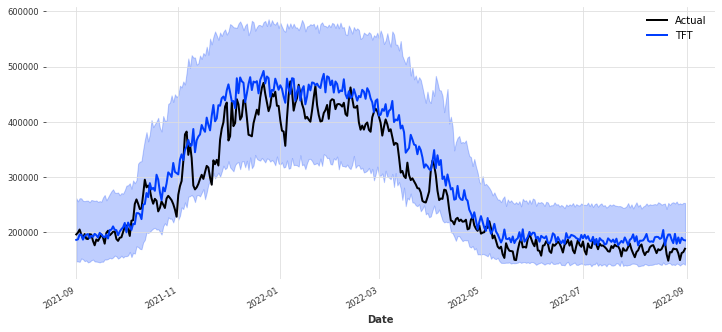

In [52]:
plt.figure(101, figsize=(12, 5))
test_unsc[-365:].plot(label='Actual')
pred_tft.plot(label='TFT')
tft_mae = mae(test_unsc[-365:], pred_tft)
tft_mape = mape(test_unsc[-365:], pred_tft)
print(f'MAE: {tft_mae}')
print(f'MAPE: {tft_mape}')

Best DropOut 0.35